# Data preprocessing (split to new Notebook later)
Here we throw away simulation data so we can focus on the *scores* only.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:44411 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 31.33 GiB


In [194]:
base_path = '../data/parameter_search/2021-05-19/'

no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(base_path + f'{f}.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(base_path + f'{f}.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

NameError: name 'dd' is not defined

In [3]:
client.close()

---

# Start here -- Data Ingestion
Once you've processed your data, of course.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df2 = pd.read_parquet('no_curves.parquet/').reset_index(drop=True)
df2_filtered = df2

# Feature engineering
Here we calculate all our objective functions that we use to estimate the performance of each set of model parameters.

We also calculate norms, which have the form: $F_{\text{norm}} = \frac{F - \text{min}(F)}{\text{max}(F) - \text{min}(F)}$, which theoretically compresses values between 0 and 1.

In [4]:
# Do some shuffling of the columns
df2_filtered['dtw_mech'] = df2_filtered['y_diff_dtw_euclid_norm']
df2_filtered['dtw_elec'] = df2_filtered['emf_dtw_euclid_norm'] 
df2_filtered['rms_perc_diff'] = df2_filtered['rms_perc_diff']

def calc_norm(series):
    """Calculate the norm of a metric."""
    return (series - series.min())/(series.max() - series.min())

# Norm and objective function calculation
df2_filtered['rms_perc_abs'] = np.abs(df2_filtered['rms_perc_diff'])
df2_filtered['dtw_mech_norm'] = calc_norm(df2_filtered['dtw_mech'])
df2_filtered['dtw_elec_norm'] = calc_norm(df2_filtered['dtw_elec'])
df2_filtered['rms_perc_abs_norm'] = calc_norm(df2_filtered['rms_perc_abs'])

df2_filtered['dtw_both'] = df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['rms_dtw_elec'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['balanced'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']

df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,model_id,y_diff_dtw_distance,y_diff_dtw_euclid_norm,rms_perc_diff,emf_dtw_distance,emf_dtw_euclid_norm,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,...,device_id,dtw_mech,dtw_elec,rms_perc_abs,dtw_mech_norm,dtw_elec_norm,rms_perc_abs_norm,dtw_both,rms_dtw_elec,balanced
0,2568,9.527688,0.003779,-10.855414,49.759941,0.027147,2.921429,0.001667,6.666667,2.5,...,A,0.003779,0.027147,10.855414,0.164706,0.048093,0.013840,0.212799,0.061933,0.226639
1,2569,9.802418,0.003888,-13.766499,76.300675,0.027939,2.921429,0.001667,7.500000,2.5,...,A,0.003888,0.027939,13.766499,0.170820,0.050395,0.017552,0.221215,0.067947,0.238767
2,2570,17.597856,0.006981,142.298642,164.414794,0.049418,2.921429,0.001667,0.000000,5.0,...,A,0.006981,0.049418,142.298642,0.344302,0.112842,0.181428,0.457144,0.294270,0.638572
3,2571,16.102274,0.006387,122.343049,139.099252,0.046413,2.921429,0.001667,0.833333,5.0,...,A,0.006387,0.046413,122.343049,0.311019,0.104104,0.155985,0.415123,0.260089,0.571108
4,2572,12.491959,0.004955,106.528417,128.469022,0.042923,2.921429,0.001667,1.666667,5.0,...,A,0.004955,0.042923,106.528417,0.230674,0.093959,0.135821,0.324633,0.229780,0.460454


## Additional outlier removal
Certain input excitations cause all model parameters to simulate poorly. 

This is a bit of a luck of the draw, and has to do with how the base plate was held during experimentation. We remove these since they're "bad" tests that do not represent the actual behaviour in practice.

In [5]:
which_filter = 'y_diff_dtw_euclid_norm'
df2_filtered.query('device_id == "B"').groupby(['input_excitation']).agg({'balanced': 'mean', which_filter: 'mean'}).style.background_gradient(cmap='Reds')

,balanced,y_diff_dtw_euclid_norm
input_excitation,,
0,0.282975,0.003742
1,0.248976,0.003285
2,0.269404,0.003588
3,0.318914,0.004348
4,0.237869,0.003106
5,0.299894,0.003871
6,0.202096,0.002683


In [6]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({which_filter: 'mean'})
        .sort_values(by=which_filter, ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

indexes_to_drop = []
dropped_inputs = {}
for device, num in zip(['A', 'B', 'C'], [2, 2, 2]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)
    dropped_inputs[device] = to_drop
    
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)
    
dropped_inputs

{'A': array([4, 1]), 'B': array([3, 5]), 'C': array([2, 6])}

In [7]:
print(len(df2))
len(df2_filtered)

165000


120000

# Remove outliers
Anything more than 3 standard deviations out we consider outliers, and remove from the dataset.

We don't want to skew our results using severe outliers that can sometimes occur due to buggy simulations with particularly bad parameters.

In [8]:
def drop_outliers(criteria: str, df) -> pd.DataFrame:
    percent_samples = 0.9973  # Outside of 3 standard deviations
    cut_off = (1-percent_samples)/2
    upper_bound = df[criteria].quantile(percent_samples)
    lower_bound = df[criteria].quantile(1-(percent_samples + cut_off))

    to_drop_lower = df.query(f'{criteria} < {lower_bound}')['model_id'].values
    to_drop_upper = df.query(f'{criteria} > {upper_bound}')['model_id'].values

    to_drop = np.concatenate([to_drop_lower, to_drop_upper])

    return df[~df2_filtered['model_id'].isin(to_drop)]

In [9]:
df2_filtered = drop_outliers(criteria='rms_perc_diff', df=df2_filtered)
print(len(df2))
len(df2_filtered)

165000


114480

In [10]:
df2_filtered = df2_filtered.query('-100 < rms_perc_diff < 100')

In [11]:
#df2_filtered = df2_filtered.drop(df2_filtered.query('input_excitation == 4 and device_id == "A"').index)

In [12]:
len(df2_filtered)

112874

# Get the best parameter set for each objective function

## Step 1: Have each distance score "vote" on which `model_id` is closest to each measurement.
Here, we use treat each distance score as a "model" that "votes" for the `model_id` that produces the lowest distance.

In [32]:
scores = ['rms_perc_abs']

In [33]:
votes = []
for device in ['A', 'B', 'C']:
    for input_ in df2_filtered.query(f'device_id == "{device}"')['input_excitation'].unique():
        df_sample = df2_filtered.query(f'device_id == "{device}" and input_excitation == {input_}')
        for s in scores:
            votes.append(df_sample.sort_values(by=s, ascending=True)['model_id'].iloc[0])
            
np.unique(votes, return_counts=True)  # This isn't very fruitful, is it XD

(array([ 212,  572, 1090, 1520, 1560, 2264, 2410, 2500, 2511, 2755, 3256,
        3513, 4921, 5101, 5994, 7051]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [34]:
import plotly.express as px

df_3d_chosen = df2_filtered[df2_filtered['model_id'].isin(votes)][['damper.cdc', 'coupling_model.coupling_constant', 'mechanical_spring.damping_coefficient']]

df2_filtered['chosen'] = df2_filtered['model_id'].apply(lambda x: 'Yes' if x in votes else 'No')

## Step 2: Take the _mean_ of all the voted-for parameter sets
And we'll weight them according to the number of votes they got.

In [36]:
model_ids, weights = np.unique(votes, return_counts=True)
weight_dict = {model_id: weight for model_id, weight in zip(model_ids, weights)}

df2_avg = df2_filtered[df2_filtered['model_id'].isin(model_ids)]
df2_avg = df2_avg.copy()
df2_avg['weight'] = df2_avg['model_id'].apply(lambda x: weight_dict[x])  # Weight according to number of votes

# We're interested in our model parameters + weights
cols_of_interest = ['damper.cdc', 'damper.mdc', 'coupling_model.coupling_constant', 'mechanical_spring.damping_coefficient', 'weight']  
df2_avg = df2_avg[cols_of_interest]

new_data = {}
for col in df2_avg.columns:
    new_data[col] = df2_avg[col]*df2_avg['weight']  # apply weights
    
df2_avg = pd.DataFrame(new_data)
vals = df2_avg.mean()  # Take the parameter mean
print('Our meaned parameters:')
print('======================')
vals

Our meaned parameters:


damper.cdc                               3.387682
damper.mdc                               0.005438
coupling_model.coupling_constant         1.656073
mechanical_spring.damping_coefficient    2.987288
weight                                   1.000000
dtype: float64

# Simulate the new model parameters
Since we've never simulated these parameters, we'll need to do that.

In [37]:
from unified_model import gridsearch
from unified_model import evaluate
from unified_model import metrics
from unified_model import mechanical_components
from unified_model.mechanical_model import MechanicalModel
from unified_model.electrical_model import ElectricalModel
from unified_model.unified import UnifiedModel
from unified_model.mechanical_components import QuasiKarnoppDamper, MagnetAssembly, MagneticSpringInterp, MechanicalSpring
from unified_model.electrical_components.load import SimpleLoad
from unified_model.governing_equations import unified_ode
from unified_model.coupling import CouplingModel
from unified_model.utils.utils import collect_samples
from unified_model import pipeline
from scipy.signal import savgol_filter
import cloudpickle
import shutil


# Prepare data
with open('../scripts/ABC.config', 'rb') as f:
    ABC_CONFIG = cloudpickle.load(f)

# Define unified model prototype
magnet_assembly = ABC_CONFIG.magnet_assembly
magnetic_spring = ABC_CONFIG.spring
damper = QuasiKarnoppDamper(
    coulomb_damping_coefficient=vals['damper.cdc'],
    motional_damping_coefficient=vals['damper.mdc'],
    magnet_assembly=magnet_assembly,
    tube_inner_radius_mm=5.5
)
mechanical_spring = MechanicalSpring(
    magnet_assembly=magnet_assembly,
    position=110/1000,
    damping_coefficient=vals['mechanical_spring.damping_coefficient']
)
magnetic_spring = MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10 / 1000,
    filter_callable=lambda x: savgol_filter(x, 27, 5)
)
load_model = SimpleLoad(30)
rectification_drop = 0.05

coil_configuration = None # ABC_CONFIG.coil_configs['A']  # HANDLE
flux_model = None
dflux_model = None
coupling_model = CouplingModel().set_coupling_constant(vals['coupling_model.coupling_constant'])

unified_model_prototype = UnifiedModel()

mechanical_model = MechanicalModel() \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mechanical_spring) \
    .set_damper(damper) \
    .set_magnet_assembly(magnet_assembly)

electrical_model = ElectricalModel() \
    .set_load_model(load_model) \
    .set_rectification_drop(0.05)

unified_model_prototype = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling_model) \
    .set_governing_equations(unified_ode) \
    .set_post_processing_pipeline(pipeline.clip_x2, 'clip_x2')

# Export the prototype for use somewhere else
unified_model_prototype.save_to_disk('um_prototype.model/', overwrite=True)

In [38]:
def run_for_multiple_inputs(prototype, which_device, vals):  # Ugly function to make things easier to do
    # Clean old data up first
    try:
        shutil.rmtree(f'{which_device}_optim.parquet/')
    except FileNotFoundError:
        pass
    
        
    BASE_GROUNDTRUTH_PATH = '../data/2019-05-23_D/'
    samples = {}
    samples['A'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                                   acc_pattern='A/*acc*.csv',
                                   adc_pattern='A/*adc*.csv',
                                   video_label_pattern='A/*labels*.csv')
    samples['B'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                                   acc_pattern='B/*acc*.csv',
                                   adc_pattern='B/*adc*.csv',
                                   video_label_pattern='B/*labels*.csv')
    samples['C'] = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                                   acc_pattern='C/*acc*.csv',
                                   adc_pattern='C/*adc*.csv',
                                   video_label_pattern='C/*labels*.csv')

    which_input = np.array(range(len(samples[which_device])))
    which_input = [input_ for input_ in which_input if input_ not in dropped_inputs[which_device]]  # Filter out dropped inputs

    mech_components = {
        'magnetic_spring': [prototype.mechanical_model.magnetic_spring],
        'magnet_assembly': [prototype.mechanical_model.magnet_assembly],
        'damper': [prototype.mechanical_model.damper],
        'mechanical_spring': [prototype.mechanical_model.mechanical_spring]
    }

    elec_components = {
        'rectification_drop': [prototype.electrical_model.rectification_drop],
        'load_model': [prototype.electrical_model.load_model],
        'coil_configuration': [ABC_CONFIG.coil_configs[which_device]],
        'flux_model': [ABC_CONFIG.flux_models[which_device]],
        'dflux_model': [ABC_CONFIG.dflux_models[which_device]],

    }
    coupling_models = [prototype.coupling_model]
    governing_equations = [prototype.governing_equations]


    # Models we want to simulate
    abstract_model_factory = gridsearch.AbstractUnifiedModelFactory(
        mech_components,
        elec_components,
        coupling_models,
        governing_equations
    )



    # Curves we want to capture
    curve_expressions = {
        't': 'time',
        'x3-x1': 'y_diff',
        'g(t, x5)': 'emf'
    }
    
    # Groundtruth
    groundtruth_factory = evaluate.GroundTruthFactory(samples_list=samples[which_device],  # noqa
                                             lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                             seconds_per_frame=1 / 60,  # noqa
                                                             pixel_scale=0.154508),
                                             adc_kwargs=dict(voltage_division_ratio=1 / 0.342))  # noqa


    # TODO: Consider changing the factory to make it more user-friendly
    groundtruth = groundtruth_factory.make()
    mech_y_targets = [gt.mech['y_diff'] for gt in groundtruth]
    mech_time_targets = [gt.mech['time'] for gt in groundtruth]
    elec_emf_targets = [gt.elec['emf'] for gt in groundtruth]
    elec_time_targets = [gt.elec['time'] for gt in groundtruth]

    input_excitation_factories = {device: gridsearch.AccelerometerInputsFactory(samples[device])
                                  for device in ['A', 'B', 'C']}

    # Inputs we want to excite the system with
    input_excitations = input_excitation_factories[which_device].make()[which_input]
    
    # Expressions we want to score
    score_metrics = {
        'x3-x1': gridsearch.EvaluatorFactory(evaluator_cls=evaluate.MechanicalSystemEvaluator,
                                             expr_targets=mech_y_targets,
                                             time_targets=mech_time_targets,
                                             metrics={'y_diff_dtw_distance': metrics.dtw_euclid_distance,
                                                      'y_diff_dtw_euclid_norm': metrics.dtw_euclid_norm_by_length,
                                                      'dy_diff_dtw_distance': metrics.deriv_dtw_euclid_distance,
                                                      'dy_diff_dtw_euclid_norm': metrics.deriv_dtw_euclid_norm_by_length}).make()[which_input],  # noqa

        'g(t, x5)': gridsearch.EvaluatorFactory(evaluator_cls=evaluate.ElectricalSystemEvaluator,  # noqa
                                                expr_targets=elec_emf_targets,
                                                time_targets=elec_time_targets,
                                                metrics={'rms_perc_diff': metrics.root_mean_square_percentage_diff,  # noqa
                                                         'emf_dtw_distance': metrics.dtw_euclid_distance,
                                                         'emf_dtw_euclid_norm': metrics.dtw_euclid_norm_by_length}).make()[which_input]  # noqa
    }

    # Metrics we want to calculate
    calc_metrics = None

    # Parameters we want to track
    parameters_to_track = [
        'damper.cdc',
        'damper.mdc',
        'coupling_model.coupling_constant',
        'mechanical_spring.damping_coefficient',
        'coil_config.coil_resistance',
        'load_model.R'
    ]


    # Run the gridsearch
    grid_executor = gridsearch.GridsearchBatchExecutor(abstract_model_factory,
                                                       input_excitations,
                                                       curve_expressions,
                                                       score_metrics,
                                                       calc_metrics=calc_metrics,  # noqa <-- use this for optimization, not scoring
                                                       parameters_to_track=parameters_to_track)  # noqa

    grid_executor.run(f'{which_device}_optim.parquet', batch_size=24)  # Execute

run_for_multiple_inputs(unified_model_prototype, which_device='A', vals=vals)
run_for_multiple_inputs(unified_model_prototype, which_device='B', vals=vals)
run_for_multiple_inputs(unified_model_prototype, which_device='C', vals=vals)

df_a = pd.read_parquet('A_optim.parquet/').drop(columns=['time', 'y_diff', 'emf']).drop_duplicates()
df_b = pd.read_parquet('B_optim.parquet/').drop(columns=['time', 'y_diff', 'emf']).drop_duplicates()
df_c = pd.read_parquet('C_optim.parquet/').drop(columns=['time', 'y_diff', 'emf']).drop_duplicates()

df_optim = pd.concat([df_a, df_b, df_c]).reset_index(drop=True)
df_optim.head()

2021-05-28 15:42:33,674 :: INFO :: Starting Ray...
2021-05-28 15:42:34,528	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
2021-05-28 15:42:36,049 :: INFO :: Running grid search...
2021-05-28 15:42:38,057 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:40,058 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:42,062 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:44,064 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:46,064 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:48,066 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:50,068 :: INFO :: Progress: :: Input: 1/5 :: 0/1
2021-05-28 15:42:52,069 :: INFO :: Progress: :: Input: 1/5 :: 0/1
(pid=30343) /home/michael/Nextcloud/nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py:8: RuntimeWarning: overflow encountered in exp
(pid=30343)   return 1 / (1 + np.exp(-(5*x - x0))) - 0.5
(pid=30343) /home/michael/Nextcloud/nextcloud

,model_id,y_diff_dtw_distance,y_diff_dtw_euclid_norm,dy_diff_dtw_distance,dy_diff_dtw_euclid_norm,rms_perc_diff,emf_dtw_distance,emf_dtw_euclid_norm,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,input_excitation
0,0,9.870361,0.003917,0.404895,0.000161,96.474322,111.338474,0.037076,3.387682,0.005438,1.656073,2.987288,12.5,30,0
1,0,7.846284,0.002081,0.229957,0.000061,19.242174,71.604354,0.031337,3.387682,0.005438,1.656073,2.987288,12.5,30,1
2,0,6.740908,0.001950,0.232293,0.000067,51.463605,69.569646,0.029541,3.387682,0.005438,1.656073,2.987288,12.5,30,2
3,0,7.970716,0.002306,0.226777,0.000066,18.542724,77.888724,0.027493,3.387682,0.005438,1.656073,2.987288,12.5,30,3
4,0,8.222309,0.002181,0.282731,0.000075,38.931796,81.883143,0.026856,3.387682,0.005438,1.656073,2.987288,12.5,30,4


In [39]:
df_optim.mean()

model_id                                  0.000000
y_diff_dtw_distance                       7.080362
y_diff_dtw_euclid_norm                    0.002543
dy_diff_dtw_distance                      0.199682
dy_diff_dtw_euclid_norm                   0.000071
rms_perc_diff                            11.489311
emf_dtw_distance                         66.229442
emf_dtw_euclid_norm                       0.030579
damper.cdc                                3.387682
damper.mdc                                0.005438
coupling_model.coupling_constant          1.656073
mechanical_spring.damping_coefficient     2.987288
coil_config.coil_resistance              17.925000
load_model.R                             30.000000
input_excitation                          2.187500
dtype: float64

In [40]:
%matplotlib widget
sns.histplot(x='rms_perc_diff', data=df_optim, bins=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='rms_perc_diff', ylabel='Count'>

In [41]:
%matplotlib widget
sns.histplot(x='y_diff_dtw_distance', data=df_optim, bins=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<AxesSubplot:xlabel='y_diff_dtw_distance', ylabel='Count'>

# Comparisons to groundtruth data

In [42]:
from unified_model.evaluate import Groundtruth
import copy

In [43]:
with open('../scripts/ABC.config', 'rb') as f:
    ABC_CONFIG = cloudpickle.load(f)
    
class Measurement:
    def __init__(self, sample):
        self.sample = sample
        self.input_ = None
        self.groundtruth = None
        
        self.input_, self.groundtruth = self._make_measurement(self.sample)
    
    def _make_measurement(self, sample):
        acc_input = mechanical_components.AccelerometerInput(
            raw_accelerometer_input=sample.acc_df,
            accel_column='z_G',
            time_column='time(ms)',
            accel_unit='g',
            time_unit='ms',
            smooth=True,
            interpolate=True
        )

        ground_truth = Groundtruth(
            sample=sample,
            lvp_kwargs={
                'magnet_assembly': ABC_CONFIG.magnet_assembly,
                'seconds_per_frame': 1/60,
                'pixel_scale': 0.154508
            },
            adc_kwargs=None
        )
        
        return acc_input, ground_truth

In [44]:
def compare(model_prototype: UnifiedModel, measurement: Measurement, poof=True, **model_overrides):
    model = copy.deepcopy(model_prototype)
    
    # TODO: Make this nicer
    # Update or proto model with config
    model.electrical_model.set_flux_model(model_overrides['flux_model'], model_overrides['dflux_model'])
    model.electrical_model.set_coil_configuration(model_overrides['coil_config'])
    model.mechanical_model.set_input(measurement.input_)
     
    model.solve(
        t_start=0,
        t_end=8,
        t_max_step=1e-2,
        t_eval=np.arange(0., 8., 1e-3),
        y0=[0.0, 0.0, 0.04, 0.0, 0.0]
    )
    
    results = model.get_result(
        time='t',
        x_pos='x3-x1',
        x_vel='x4-x2',
        emf='g(t, x5)'
    )
    
    # Do mech first
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target=measurement.groundtruth.mech['y_diff'],
        time_target=measurement.groundtruth.mech['time'],
        metrics={
            'y_diff_dtw_distance': metrics.dtw_euclid_distance
        }
    )
    mech_eval.fit(
        y_predict=results['x_pos'].values,
        time_predict=results['time'].values
    )
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=measurement.groundtruth.elec['emf'],
        time_target=measurement.groundtruth.elec['time'],
        metrics={
            'emf_diff_dtw_distance': metrics.dtw_euclid_distance,
            'rms_perc_diff': metrics.root_mean_square_percentage_diff
        }
    )
    elec_eval.fit(
        emf_predict=results['emf'].values,
        time_predict=results['time'].values
    )
    
        
    if poof:
        print(mech_eval.score())
        mech_eval.poof()
        print(elec_eval.score())
        elec_eval.poof()
    return mech_eval, elec_eval
    

## Prepare the data for comparisons

In [45]:
BASE_GROUNDTRUTH_PATH = '../data/2019-05-23_D/'
SAMPLES_A = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                            acc_pattern='A/*acc*.csv',
                            adc_pattern='A/*adc*.csv',
                            video_label_pattern='A/*labels*.csv')
SAMPLES_B = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                            acc_pattern='B/*acc*.csv',
                            adc_pattern='B/*adc*.csv',
                            video_label_pattern='B/*labels*.csv')
SAMPLES_C = collect_samples(base_path=BASE_GROUNDTRUTH_PATH,
                            acc_pattern='C/*acc*.csv',
                            adc_pattern='C/*adc*.csv',
                            video_label_pattern='C/*labels*.csv')


DEVICE_A = {
    'flux_model': ABC_CONFIG.flux_models['A'],
    'dflux_model': ABC_CONFIG.dflux_models['A'],
    'coil_config': ABC_CONFIG.coil_configs['A']
}
DEVICE_B = {
    'flux_model': ABC_CONFIG.flux_models['B'],
    'dflux_model': ABC_CONFIG.dflux_models['B'],
    'coil_config': ABC_CONFIG.coil_configs['B']
}
DEVICE_C = {
    'flux_model': ABC_CONFIG.flux_models['C'],
    'dflux_model': ABC_CONFIG.dflux_models['C'],
    'coil_config': ABC_CONFIG.coil_configs['C']
}


# Measurements
MEASUREMENTS_A = [Measurement(s) for s in SAMPLES_A]
MEASUREMENTS_B = [Measurement(s) for s in SAMPLES_B]
MEASUREMENTS_C = [Measurement(s) for s in SAMPLES_C]

## Do the comparisons

In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
%matplotlib widget
for m in MEASUREMENTS_A:
    mech_eval, elec_eval = compare(unified_model_prototype, m, **DEVICE_A)

{'y_diff_dtw_distance': 9.870360744546245}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 111.33847441862308, 'rms_perc_diff': 96.47432203771199}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 11.170046062174816}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 72.05865242622475, 'rms_perc_diff': 20.440601486515764}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 7.846283914364181}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 71.60435386824336, 'rms_perc_diff': 19.24217423135797}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 6.7409079338623}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 69.56964629698078, 'rms_perc_diff': 51.46360461621063}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 16.725654631044225}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 85.98338253546666, 'rms_perc_diff': -33.48671668390073}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 7.970715933972386}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 77.88872416218643, 'rms_perc_diff': 18.542724425409517}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 8.222309444469742}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'emf_diff_dtw_distance': 81.88314323518928, 'rms_perc_diff': 38.93179573660262}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'y_diff_dtw_distance': 9.564734351893321}


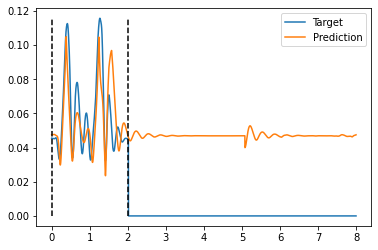

{'emf_diff_dtw_distance': 78.95076589038477, 'rms_perc_diff': -4.061030132608901}


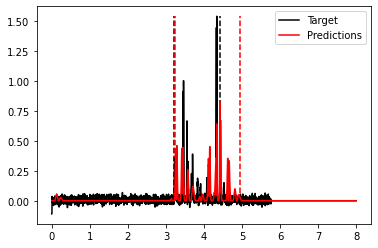

{'y_diff_dtw_distance': 7.454726925058828}


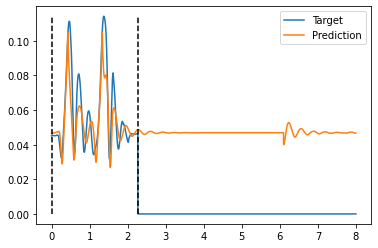

{'emf_diff_dtw_distance': 60.379081571588294, 'rms_perc_diff': -18.258437545347032}


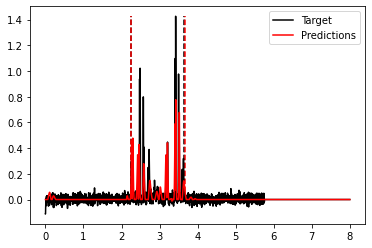

{'y_diff_dtw_distance': 6.746159551451104}


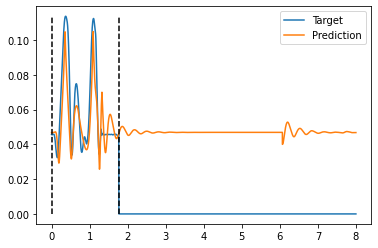

{'emf_diff_dtw_distance': 69.22574153947146, 'rms_perc_diff': -2.1586737879107587}


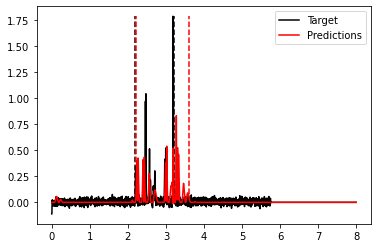

{'y_diff_dtw_distance': 10.2298574857364}


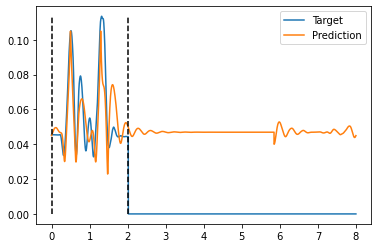

{'emf_diff_dtw_distance': 58.85575916715988, 'rms_perc_diff': 7.922192555163436}


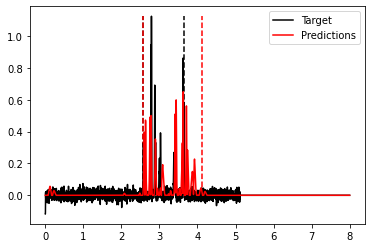

{'y_diff_dtw_distance': 8.690517062328748}


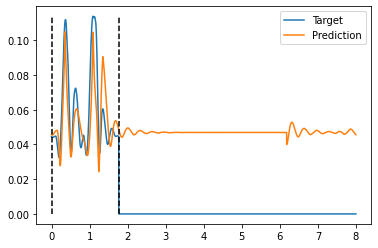

{'emf_diff_dtw_distance': 48.72986987535794, 'rms_perc_diff': -7.666568362766204}


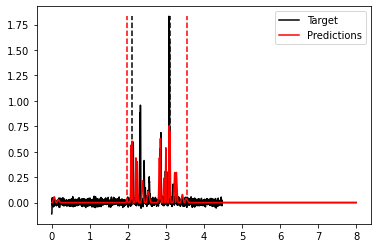

{'y_diff_dtw_distance': 8.983426082313697}


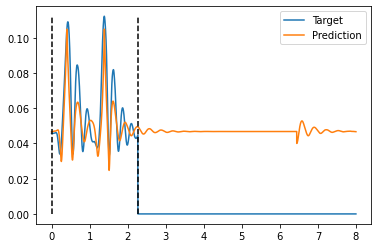

{'emf_diff_dtw_distance': 55.59863357425576, 'rms_perc_diff': -23.50970667943288}


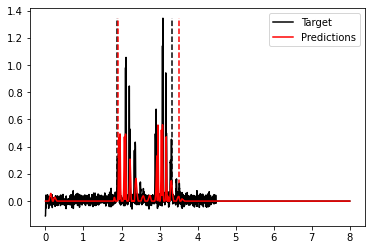

{'y_diff_dtw_distance': 7.34849717703774}


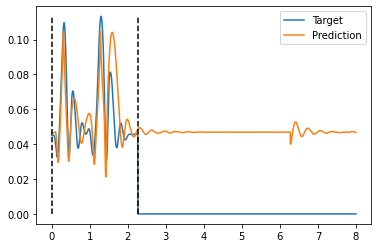

{'emf_diff_dtw_distance': 61.3450337278359, 'rms_perc_diff': 4.2775733201145725}


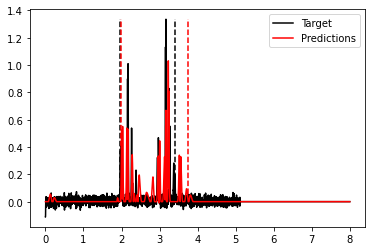

In [125]:
%matplotlib inline
for m in MEASUREMENTS_B:
    mech_eval = compare(unified_model_prototype, m, **DEVICE_B)

{'y_diff_dtw_euclid_norm': 0.002496566872640971}


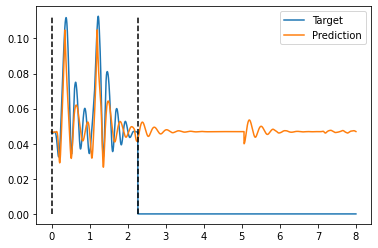

{'emf_diff_dtw_euclid_norm': 0.02593418628133453, 'rms_perc_diff': -16.981763924746083}


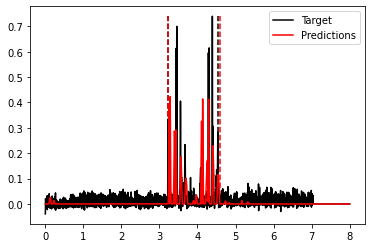

{'y_diff_dtw_euclid_norm': 0.001002874924301068}


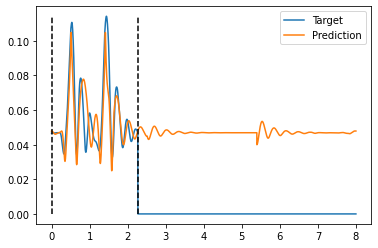

{'emf_diff_dtw_euclid_norm': 0.02398364572941673, 'rms_perc_diff': -7.650180257615968}


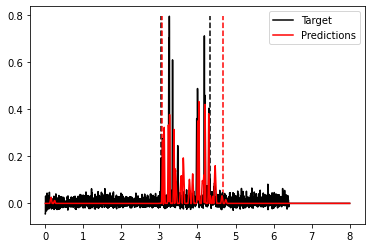

{'y_diff_dtw_euclid_norm': 0.005983165422398779}


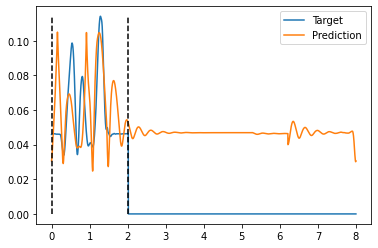

{'emf_diff_dtw_euclid_norm': 0.029850144332394843, 'rms_perc_diff': 23.6664110473717}


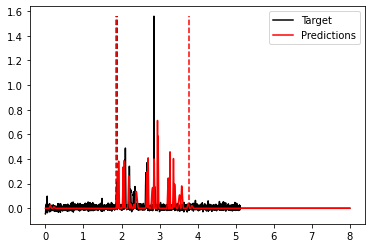

{'y_diff_dtw_euclid_norm': 0.003488143335948679}


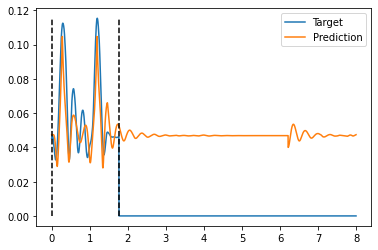

{'emf_diff_dtw_euclid_norm': 0.021379592976368603, 'rms_perc_diff': -0.9399616102127153}


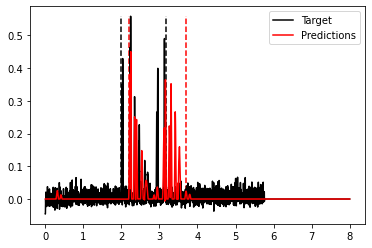

{'y_diff_dtw_euclid_norm': 0.0015132052833997693}


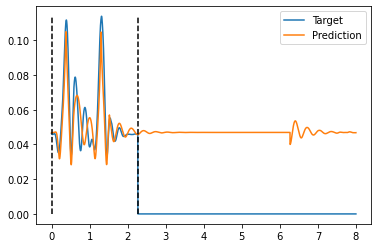

{'emf_diff_dtw_euclid_norm': 0.02766669870093966, 'rms_perc_diff': -13.906270677570513}


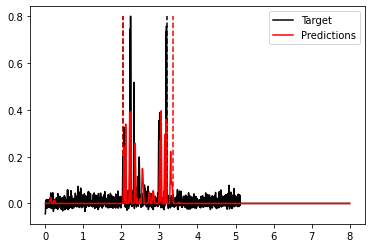

{'y_diff_dtw_euclid_norm': 0.0012282413012440953}


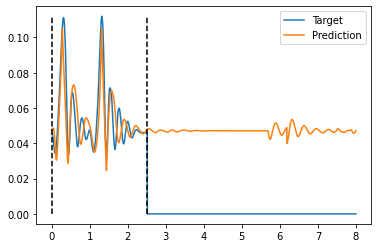

{'emf_diff_dtw_euclid_norm': 0.025742173902824753, 'rms_perc_diff': -8.020531660175415}


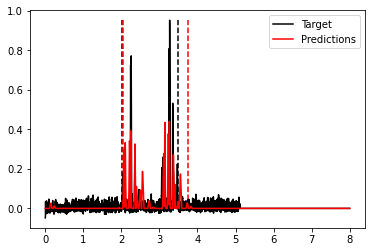

{'y_diff_dtw_euclid_norm': 0.003549774661946295}


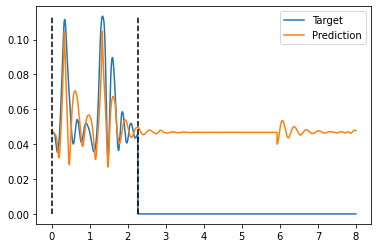

{'emf_diff_dtw_euclid_norm': 0.02689293499155198, 'rms_perc_diff': -0.4029427056442976}


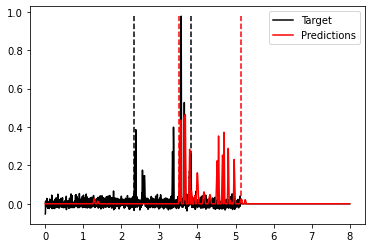

{'y_diff_dtw_euclid_norm': 0.002609462985924806}


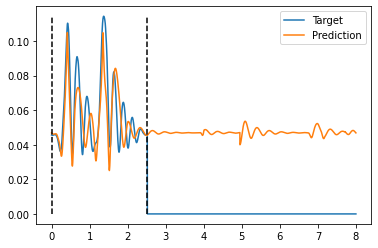

{'emf_diff_dtw_euclid_norm': 0.02652732941571475, 'rms_perc_diff': -17.685284434901785}


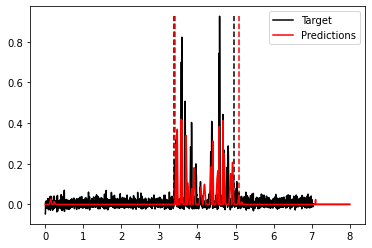

In [62]:

%matplotlib inline
for m in MEASUREMENTS_C:
    mech_eval = compare(unified_model_prototype, m, **DEVICE_C)

---

In [63]:
df_scores = df2_filtered.groupby(['model_id']).agg({
    'dtw_mech': 'mean',
    'dtw_elec': 'mean',
    'dtw_both': 'mean',
    'rms_perc_abs': 'mean',
    'rms_dtw_elec': 'mean',
    'balanced': 'mean'
})
df_scores.head()

,dtw_mech,dtw_elec,dtw_both,rms_perc_abs,rms_dtw_elec,balanced
model_id,,,,,,
0,0.011009,0.076497,0.761860,172.025811,0.410897,0.981189
1,0.007695,0.045483,0.485802,85.292169,0.210146,0.594548
2,0.005425,0.038234,0.337371,51.342247,0.145786,0.402831
3,0.004305,0.033474,0.260688,36.829908,0.113446,0.307645
4,0.003467,0.031965,0.209273,28.781580,0.098796,0.245968


In [64]:
# Get the best performing model ids for each objective function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func, ascending=True).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'dtw_mech': 1324,
 'dtw_elec': 8,
 'dtw_both': 3073,
 'rms_perc_abs': 5980,
 'rms_dtw_elec': 6890,
 'balanced': 3073}

In [65]:
df2_filtered.query('`model_id` == 3073').mean() # Check out the parameters

model_id                                 3073.000000
y_diff_dtw_distance                         6.691948
y_diff_dtw_euclid_norm                      0.002365
rms_perc_diff                              -2.900681
emf_dtw_distance                           58.181589
emf_dtw_euclid_norm                         0.028982
damper.cdc                                  3.485714
damper.mdc                                  0.001667
coupling_model.coupling_constant            2.500000
mechanical_spring.damping_coefficient       5.000000
coil_config.coil_resistance                17.925000
load_model.R                               30.000000
input_excitation                            3.062500
dtw_mech                                    0.002365
dtw_elec                                    0.028982
rms_perc_abs                               16.081835
dtw_mech_norm                               0.085380
dtw_elec_norm                               0.053430
rms_perc_abs_norm                           0.

In [21]:
best_param_sets = [v for v in best_model_ids.values()]

In [22]:
letters = [r'$A$', r'$B$', r'$C$', r'$D$', r'$E$', r'$F$', 'G']
letter_index = 0
seen_model_ids = []
model_id_to_letter_mapping = {}

for k, v in best_model_ids.items():
    if v not in model_id_to_letter_mapping.keys():
        model_id_to_letter_mapping[v] = letters[letter_index]
        letter_index += 1

In [23]:
model_id_to_letter_mapping 

{3193: '$A$', 120: '$B$', 20: '$C$', 180: '$D$'}

## Filter according to the best parameter sets

In [24]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets)]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_letter_mapping[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # To not have latex rendering complain
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,model.id,y.diff.dtw.distance,y.diff.dtw.euclid.norm,rms.perc.diff,emf.dtw.distance,emf.dtw.euclid.norm,damper.cdc,damper.mdc,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,...,dtw.mech,dtw.elec,rms.perc.abs,dtw.mech.norm,dtw.elec.norm,rms.perc.abs.norm,dtw.both,rms.dtw.elec,balanced,metric.name
17377,3193,9.702974,0.002573,7.727187,64.027915,0.028281,3.485714,0.005,2.5,10.0,...,0.002573,0.028281,7.727187,0.097030,0.051390,0.009852,0.148420,0.061242,0.158272,$A$
23845,3193,8.779503,0.002539,35.368343,67.145572,0.028189,3.485714,0.005,2.5,10.0,...,0.002539,0.028189,35.368343,0.095114,0.051122,0.045094,0.146236,0.096216,0.191330,$A$
38461,3193,9.543907,0.002760,12.024604,71.013693,0.027313,3.485714,0.005,2.5,10.0,...,0.002760,0.027313,12.024604,0.107516,0.048576,0.015331,0.156092,0.063907,0.171423,$A$
51013,3193,9.586184,0.002542,23.609786,68.293229,0.024140,3.485714,0.005,2.5,10.0,...,0.002542,0.024140,23.609786,0.095293,0.039353,0.030102,0.134645,0.069454,0.164747,$A$
55705,3193,6.073406,0.002409,-13.145229,67.147511,0.040720,3.485714,0.005,2.5,10.0,...,0.002409,0.040720,13.145229,0.087834,0.087554,0.016760,0.175388,0.104314,0.192148,$A$


# Plots

In [25]:
df_filtered_scores_melt = df_filtered_scores.melt(id_vars=['model.id', 'metric.name'])
df_filtered_scores_melt.to_csv('best_param_set_scores.csv')  # Write out

In [26]:
def phd_theme():
    return theme(
        axis_line=element_line(color='black', size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_title_x=element_text(size=16, margin={'t': 12}),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=16),
        axis_text=element_text(size=12),
        panel_background=element_blank(),
        panel_border=element_blank(),
        panel_grid=element_blank(),
        legend_key=element_blank(),
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_position=(0.8, 0.8),
        legend_direction='vertical',
    )

In [27]:
from plotnine import *
from matplotlib import rc
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{amsmath}')
rc('text', usetex=True)

df_plot = df_filtered_scores_melt[df_filtered_scores_melt['variable'].isin(['emf.dtw.euclid.norm', 'y.diff.dtw.euclid.norm', 'rms.perc.diff'])]
df_plot['value'] = df_plot['value'].astype(float)

cols_rename = {'emf.dtw.euclid.norm': r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$',
               'y.diff.dtw.euclid.norm': r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}})$',
               'rms.perc.diff': r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$'}

lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='metric.name', y='value'), df_plot)
p = (
    p
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free_y', labeller=lblr)
    + phd_theme()
    + theme(figure_size=(4, 8))
    + xlab('Parameter Set')
    + ylab('Value')
)
#p.save('/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ggplot: (8771676576153)>

In [28]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

Client Scheduler: tcp://127.0.0.1:34587 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 31.33 GiB


In [98]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

class GroundTruthFactory:
    def __init__(self,
                 samples_list,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 7, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            try:
                mech_groundtruth = self._make_mechanical_groundtruth(sample)
                elec_groundtruth = self._make_electrical_groundtruth(sample)

                groundtruths.append(
                    Groundtruth(mech_groundtruth, elec_groundtruth)
                )
            except AttributeError:
                pass

        return groundtruths
# Prepare data
base_groundtruth_path = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [99]:
# Groundtruth

from unified_model.mechanical_components.magnet_assembly import MagnetAssembly
magnet_assembly = MagnetAssembly(
    m=1,
    l_m_mm=10,
    l_mcd_mm=0,
    dia_magnet_mm=10,
    dia_spacer_mm=10,
)

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples[device],
                                            lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                            seconds_per_frame=1/60,
                                                            pixel_scale=0.154508),
                                            adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
    groundtruth[device] = groundtruth_factory.make()

In [100]:
# Let's look at some examples from each

In [101]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'time', 'emf', 'y_diff'],
                                filters=[('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp.compute()
    return df_temp.sort_values(by='time')

In [102]:
def compare_mech(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
        
    plt.figure()
    clip_index = mech_eval._clip_index
    y_predict_vel_ = np.gradient(mech_eval.y_predict_)/np.gradient(mech_eval.time_)
    y_target_vel_ = np.gradient(mech_eval.y_target_)/np.gradient(mech_eval.time_)
    plt.plot(mech_eval.time_[:clip_index], y_target_vel_[:clip_index], label='t')
    plt.plot(mech_eval.time_[:clip_index], y_predict_vel_[:clip_index], label='p')
    plt.legend()
    
    del x

In [103]:
def compare_elec(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff}
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x
    return elec_eval

In [104]:
from scipy import signal

In [105]:
%matplotlib widget

In [106]:
best_model_ids

{'dtw_mech': 3193,
 'dtw_elec': 120,
 'dtw_both': 3193,
 'rms_perc_abs': 20,
 'rms_dtw_elec': 180,
 'balanced': 3193}

In [107]:
input_ = 0
device = 'B'
chosen_model_id = 3193

compare_mech(f'../data/parameter_search/2021-05-19/{device}.parquet', groundtruth, chosen_model_id, device, input_)
ee = compare_elec(f'../data/parameter_search/2021-05-19/{device}.parquet', groundtruth, chosen_model_id, device, input_)

plt.figure(figsize=(16, 8))
plt.plot(ee.emf_predict_clipped_, 'r')
plt.plot(ee.emf_target_clipped_, 'k')

{'dtw_distance': 6.05902286116691}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'dtw_distance': 66.96502506069095, 'rms_perc_diff': -13.231541816046729}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …